In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [14]:
import pandas as pd
%matplotlib inline

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Eigendecomposition of the covariance matrix

In [4]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[4.8923083  2.46635032 1.42809973 1.01233462 0.84906459 0.60181514
 0.52251546 0.08414846 0.33051429 0.29595018 0.16831254 0.21432212
 0.2399553 ]


### Total and explained variance

In [12]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

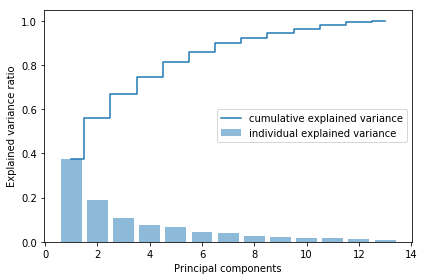

In [15]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

### Feature transformation

In [16]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Note: I added the `key=lambda k: k[0]` in the sort call above
# just like I used it further below in the LDA section.
# This is to avoid problems if there are ties in the eigenvalue
# arrays (i.e., the sorting algorithm will only regard the
# first element of the tuples, now).

In [20]:
eigen_pairs[:2]

[(4.8923083032737456,
  array([ 0.14669811, -0.24224554, -0.02993442, -0.25519002,  0.12079772,
          0.38934455,  0.42326486, -0.30634956,  0.30572219, -0.09869191,
          0.30032535,  0.36821154,  0.29259713])),
 (2.4663503157592297,
  array([ 0.50417079,  0.24216889,  0.28698484, -0.06468718,  0.22995385,
          0.09363991,  0.01088622,  0.01870216,  0.03040352,  0.54527081,
         -0.27924322, -0.174365  ,  0.36315461]))]

In [18]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


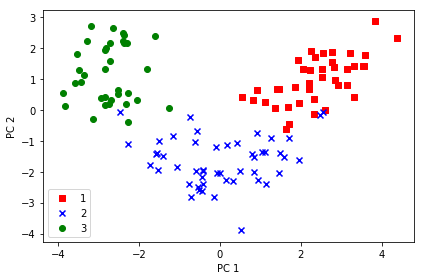

In [21]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

In [22]:
X_train_std[0].dot(w)

array([2.59891628, 0.00484089])

### Principal component analysis in scikit-learn

In [23]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.37329648, 0.18818926, 0.10896791, 0.07724389, 0.06478595,
       0.04592014, 0.03986936, 0.02521914, 0.02258181, 0.01830924,
       0.01635336, 0.01284271, 0.00642076])

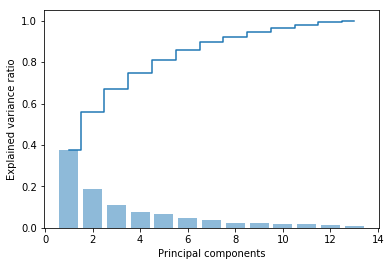

In [24]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [25]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

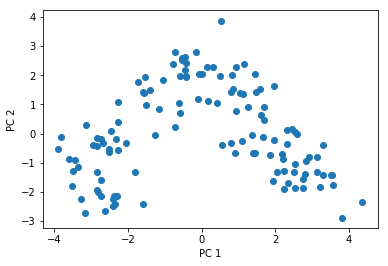

In [26]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [27]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)
        

In [28]:

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


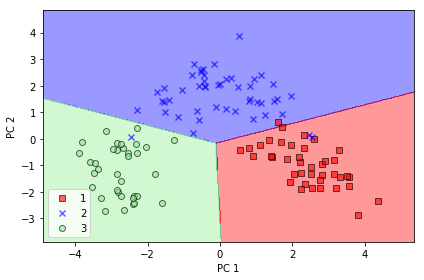

In [30]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()

In [31]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.37329648, 0.18818926, 0.10896791, 0.07724389, 0.06478595,
       0.04592014, 0.03986936, 0.02521914, 0.02258181, 0.01830924,
       0.01635336, 0.01284271, 0.00642076])